In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.decomposition import PCA
from starccato_flow.utils.defaults import SAMPLING_RATE
from starccato_flow.data.ccsn_snr_data import CCSNSNRData
from starccato_flow.pca.pca import BayesianPCR

/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MPS device found


In [3]:
# get signal here
ccsn_dataset = CCSNSNRData(noise=True, curriculum=False)
times = [1/SAMPLING_RATE * i for i in range(ccsn_dataset.signals.shape[0])]

# Fit PCA on ALL signals
signal_matrix = ccsn_dataset.signals.T  # Shape: (1684, 256)
pca = PCA(n_components=20)
pca.fit(signal_matrix)  # Learn patterns from all 1684 signals

# THEN reconstruct a single noisy signal
signal_idx = 100
true_signal, noisy_signal, _ = ccsn_dataset.__getitem__(signal_idx)
noisy_signal_np = noisy_signal.cpu().numpy().flatten()  # Get 1D array

# Create DataFrame properly: signal as COLUMN (256 rows, 1 column)
X = pd.DataFrame(noisy_signal_np, columns=['signal'])
print(f"X shape: {X.shape}")  # Should be (256, 1)

reconstructions = BayesianPCR(
    X=X,
    y_train=signal_matrix,  # Use all signals for training
    t=times,
    n=20,
    n_samples=1000,
    return_samples=True  # Get all samples for distribution analysis
)

print(f"Reconstructions shape: {reconstructions.shape}")  # Should be (1, 1000, 256)

X shape: (256, 1)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256, 1)
Reconstructions shape: (1, 1000, 256)


/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/pca/pca.py:15: RuntimeWarning: divide by zero encountered in power
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/pca/pca.py:15: RuntimeWarning: divide by zero encountered in divide
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/pca/pca.py:15: RuntimeWarning: invalid value encountered in subtract
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))


In [4]:


# # Select the first 20 principal components
# pca = PCA(n_components = 20)
# # Generate principal component matrix based on signals (y_train)
# PCx = pd.DataFrame(pca.fit_transform(signal_Tran), columns = [f'PC{i + 1}' for i in range (20)])
# # Set time as index
# PCx.index = times['time'].to_numpy()
# # Preview the first 5 principal components
# PCx.iloc[:, :5].plot(figsize = (8, 4), grid = True, linewidth = 1, xlabel = 'Time (s)')
# plt.show()


PCA reconstructions for plotting: (1000, 256)
After scaling - Min: -2.317888e+02, Max: 1.245544e+02


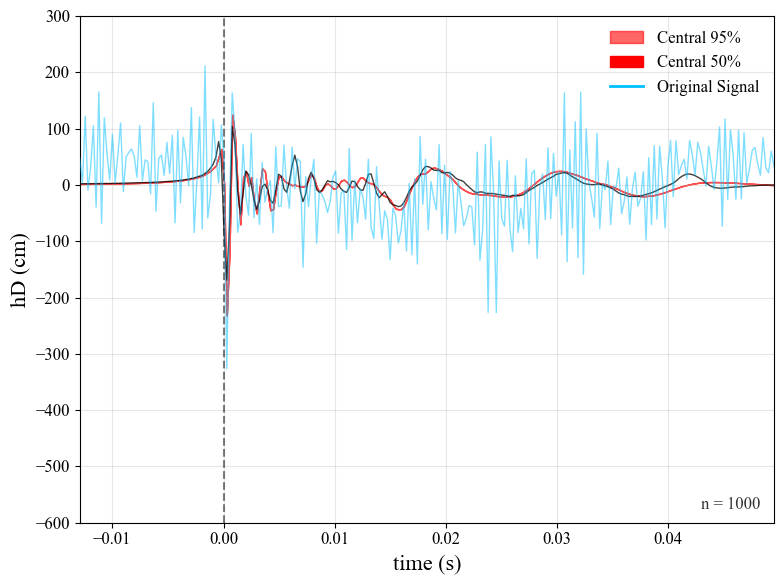

In [ ]:
# Plot the PCA reconstructions
from starccato_flow.plotting.plotting import plot_signal_distribution, plot_reconstruction_distribution

# Reshape reconstructions from (1, 1000, 256) to (1000, 256)
# This is shape: (num_samples, signal_length)
# The plotting function expects (num_samples, signal_length) and will transpose it internally
pca_reconstructions = reconstructions[0] * ccsn_dataset.max_strain  # Take first (only) signal, shape (1000, 256), scale by max_strain

print(f"PCA reconstructions for plotting: {pca_reconstructions.shape}")
print(f"After scaling - Min: {pca_reconstructions.min():.6e}, Max: {pca_reconstructions.max():.6e}")

plot_reconstruction_distribution(
    reconstructed_signals=pca_reconstructions,
    true_signal=true_signal,  # This is a tensor
    noisy_signal=noisy_signal,  # Pass the tensor, not the numpy version
    max_value=ccsn_dataset.max_strain,
    background="white",
    font_family="sans-serif",
    fname="plots/pca_reconstruction_distribution.png"
)

In [ ]:
# Debug: Check reconstruction values
print(f"Reconstructions shape: {reconstructions.shape}")
print(f"Min: {reconstructions.min():.6e}")
print(f"Max: {reconstructions.max():.6e}")
print(f"Mean: {reconstructions.mean():.6e}")
print(f"Std: {reconstructions.std():.6e}")
print(f"\nAre all samples identical? {np.allclose(reconstructions[0, 0], reconstructions[0, 1])}")
print(f"Sample variance across reconstructions: {reconstructions[0].std(axis=0).mean():.6e}")

# Check the noisy signal that was input
print(f"\nNoisy signal stats:")
print(f"Min: {noisy_signal_np.min():.6e}")
print(f"Max: {noisy_signal_np.max():.6e}")
print(f"Mean: {noisy_signal_np.mean():.6e}")